# GPT Fundamentals

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Understand what makes the "magic" of GPTs possible via foundational concepts such as word embeddings, LSTM, and the transformer architecture.
* Situate these concepts in the recent history of AI.
* Adjust hyperparameters of GPT models to control randomness. 
* Compare the output of GPT models.
* Do a simple sentiment analysis using GPT models.
    
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
🥊 **Challenge**: Interactive excersise. We'll work through these in the workshop!<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>
📝 **Poll:** A Zoom poll to help you learn!<br>
🎬 **Demo**: Showing off something more advanced – so you know what Python can be used for!<br> 

### Sections
1. [This Workshop](#this)
2. [History of GPT: Encoding Text](#hist)
3. [Transformer Architecture](#transf)
4. [Enter GPT](#GPT)
5. [Comparing Models](#comp)

<a id='this'></a>

# This Workshop 

Most of us will be using [ChatGPT](https://chat.openai.com/?model=gpt-3.5) (requires login). But how does it work? This workshop will explain foundational concepts from the recent developments in AI that make this technology work.

**📝 Poll 1**: How often do you use ChatGPT?


# On LLMs

### Running them is not expensive
<img src='../images/llama.png' alt="Language Modeling history" width="600" height="700">

### Training them is!
Think of it as compressing the internet.

<img src='../images/training.png' alt="Language Modeling history" width="600" height="700">



<a id='hist'></a>

# History of GPT: Encoding Text

<img src='../images/LM-history.png' alt="Language Modeling history" width="600" height="700">

## One Hot Encoding (1970s - 2010s)

In order to appreciate how exciting it is to capture semantic content by numbers, you should know something about how words typically were represented by computers before the early 2010s.

In order to have computers work with text. the text must be represented by numbers somehow. **One-hot encoding** represents each word as a vector of the length of the vocabulary where only the position corresponding to the word is 1, and all other positions are 0:

In [1]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Sample vocabulary
vocabulary = ['cat', 'dog', 'apple', 'orange']

# One-hot encode the vocabulary
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(np.array(vocabulary).reshape(-1, 1))

# Display one-hot encoding
print("One-Hot Encoding:")
for word, encoding in zip(vocabulary, onehot_encoded):
    print(f"{word}: {encoding}")


One-Hot Encoding:
cat: [0. 1. 0. 0.]
dog: [0. 0. 1. 0.]
apple: [1. 0. 0. 0.]
orange: [0. 0. 0. 1.]


/Users/tomvannuenen/anaconda3/envs/dlab/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


For a long time, these one-hot vectors were used as input features for various machine learning models. For example, in text classification tasks, a document or a sentence could be represented as a bag of words, where each word is a one-hot encoded vector. The model would then learn to classify the text based on these features.

The method also had some pretty serious limitations, however:

1. **High dimensionality**. Vocabularies of a language dataset can contain anything between 20 thousand and 13 million words. That’s a big vector!
2. **Semantics**. Even though we have a numerical representation of the word ‘cat’ here, it doesn’t help us much. What this method lacks is a representation of semantic relationships between words.

## Enter Word Embeddings (early 2010s)

> “You shall know a word by the company it keeps” (JR Firth 1957) 

The introduction of Word2Vec by a team at Google in 2013 marked a significant shift in the field. Word2Vec is a method to create **word embeddings**. This means to represent words in **dense vector spaces**. That means not a bunch of 0s and a 1, like we just saw, but a lot of values in one vector for every single word. The intuition behind this is that words that appear together have similar meanings. 

Word embeddings work by turning each word in our data into a vector (i.e., a list) of numbers. The values of these numbers are initiated randomly, but as the model is trained on data, these values eventually encode the meaning of words. 

We are dealing with high-dimension space here, but if we compress it to three dimensions so we can visualize it, it turns out that words with similar vectors have similar meanings. In fact, particular "directions" in the embedding space turn out to be associated with particular types of meaning. For instance, word embedding directions capture things like tenses, gender, or country-capital relations.

<img src='../images/vector.png' alt="word embeddings vectors" width="600">

Let's download a word embeddings model called [GloVe](https://nlp.stanford.edu/projects/glove/) (2014) which was pre-trained based on 2B tweets. It has 27B tokens and a vocabulary of 1.2M words. We will visualize some terms in the model by reducing the dimensionality using PCA. 

Feel free to play around with the words in `words` to see where they end up in the visualization!

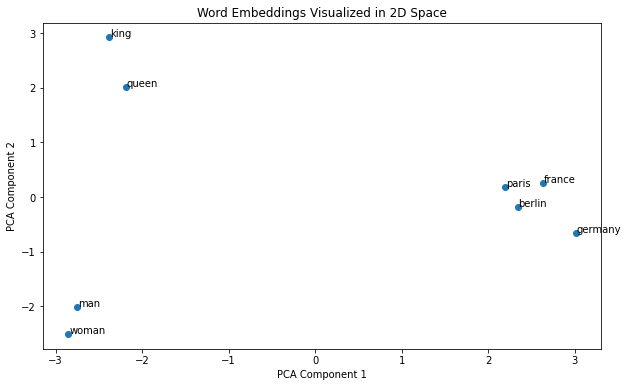

In [10]:
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Download a word embedding model
model = api.load("glove-wiki-gigaword-50")

# Select words you're interested in
words = ["king", "queen", "man", "woman", "paris", "berlin", "france", "germany"]

# Get corresponding vectors
word_vectors = [model[word] for word in words]

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

# Create a scatter plot of the projection
plt.figure(figsize=(10, 6))
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0]+0.01, result[i, 1]+0.01))

plt.title('Word Embeddings Visualized in 2D Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Without getting too deep into the math behind this, one helpful intuition is that the **dot product** of two vectors can be thought of as a measure of how well they align. Geometrically, the dot product is positive when vectors point in similar diections, and negative if they don't.

We can make use of this intuition to see if an embedding model captures particular semantic differences. For instance, let's import a word embedding model called glove, and calculate the difference between the vectors for the words "cats" and "cat". The idea is we should get a vector that captures plurality. We can then compare this vector to other words in singular or plural to check whether they are positive or negative.

In [4]:
import gensim.downloader as api

# This will list available models
print(api.info()['models'].keys())

# Download a word embedding model
model = api.load("glove-wiki-gigaword-50")

# Calculate the "plurality" vector
plurality_vector = model['cats'] - model['cat']

# Now, let's define some example singular and plural nouns for comparison
singular_nouns = ['dog', 'house', 'car']
plural_nouns = ['dogs', 'houses', 'cars']

# Function to compute the cosine similarity (as dot product)
# Note: Word2Vec embeddings are usually normalized, so dot product gives cosine similarity
def compare_similarity(reference_vector, comparison_words):
    similarities = {}
    for word in comparison_words:
        # Compute cosine similarity
        similarity = 1 - cosine(reference_vector, model[word])
        similarities[word] = similarity
    return similarities

# Compare the "plurality" vector against singular and plural nouns
singular_similarities = compare_similarity(plurality_vector, singular_nouns)
plural_similarities = compare_similarity(plurality_vector, plural_nouns)

print("Similarity with singular nouns:", singular_similarities)
print("Similarity with plural nouns:", plural_similarities)


dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])
Similarity with singular nouns: {'dog': -0.2789784371852875, 'house': -0.21839112043380737, 'car': -0.2296365648508072}
Similarity with plural nouns: {'dogs': 0.1246533989906311, 'houses': 0.16722892224788666, 'cars': 0.029727894812822342}


Let's visualize:

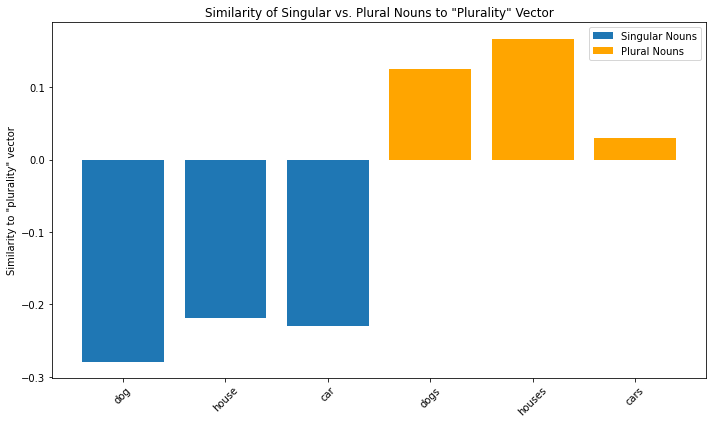

In [5]:
import matplotlib.pyplot as plt

# Assuming `singular_similarities` and `plural_similarities` are your computed dictionaries
# Example structure: {'dog': 0.8, 'house': 0.75}

# Data preparation for plotting
labels = list(singular_similarities.keys()) + list(plural_similarities.keys())
singular_scores = list(singular_similarities.values())
plural_scores = list(plural_similarities.values())

# Indices for singular and plural nouns on the x-axis
x_singular = range(len(singular_similarities))
x_plural = range(len(singular_similarities), len(singular_similarities) + len(plural_similarities))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x_singular, singular_scores, label='Singular Nouns')
plt.bar(x_plural, plural_scores, label='Plural Nouns', color='orange')

# Adding labels and title
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylabel('Similarity to "plurality" vector')
plt.title('Similarity of Singular vs. Plural Nouns to "Plurality" Vector')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Looks like the plural words do align more with the direction of our "plurality" vector!

While embeddings capture word-level relationships, they don't inherently account for word order or context beyond a fixed window. The next thing NLP had to figure out was how to handle sequence data and remember context over longer periods.

<a id='transf'></a>
# Transformer Architecture

The Transformer architecture, introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017, addresses the issue of long-term dependencies that can be challenging for the networks that came before. 

Where traditional word embedding vectors are static--each word type has one vector associated with it--the transformer architecture includes so-called **attention blocks**: layers in the neural network that allow token vectors to talk to each other, passing along information back and forth to update their values.

This is useful because words have different meanings based on the context they are in. Think of the homonym "model" (as in "language model" versus "fasion model".) Attention blocks help to figure out which contextual words are relevant for the meaning of other words.


## Encoder / Decoder

The original Transformer architecture was initially designed primarily for the task of **machine translation**. 

In order to do so, the original architecture makes use of **encoders** and **decoders**.

- Encoder: The encoder in a Transformer model processes the input data (like a sentence in a text). It analyzes and understands the context and relationships between words or tokens in the input. The encoder transforms the input into an intermediate representation that captures this information.

- Decoder: The decoder takes the intermediate representation from the encoder and generates the output data (like the translated text in another language). In the original Transformer model (used for tasks like translation), the decoder is responsible for producing a sequence based on the encoder's representation.

Vaswani et al's paper stacks 6 encoders/decoders on top of each other. This is not a magic number; just a hyperparameter. 

## Parallelization

The Transformer architecture takes advantage of **parallelization**--dividing a large computational task into smaller sub-tasks that can be executed concurrently on multiple processors or cores. This means it can process large amount of information at the same time.

Here's an example of parallel processing. 

- We have two functions, `sequential_processing` and `parallel_processing`, to perform the same task (calculating squares) in a sequential and parallel manner, respectively. 
- We then measure the time taken by each function to process a list of numbers. 
- After running this code, you can compare the time taken by each method to see the efficiency of parallel processing over sequential processing.


In [4]:
import concurrent.futures
import time

# Function to calculate the square of a number
def calculate_square(number):
    return number * number

# Sequential processing
def sequential_processing(numbers):
    results = []
    for number in numbers:
        results.append(calculate_square(number))
    return results

# Parallel processing
def parallel_processing(numbers):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(calculate_square, numbers))
    return results

# List of numbers
numbers = list(range(1, 10001))  # Numbers from 1 to 10,000

# Measuring time for sequential processing
start_time = time.time()
sequential_results = sequential_processing(numbers)
end_time = time.time()
print(f"Sequential Processing Time: {end_time - start_time} seconds")

# Measuring time for parallel processing
start_time = time.time()
parallel_results = parallel_processing(numbers)
end_time = time.time()
print(f"Parallel Processing Time: {end_time - start_time} seconds")


Sequential Processing Time: 0.0021708011627197266 seconds
Parallel Processing Time: 0.1104588508605957 seconds


## Attention Mechanism

An encoder can be broken down in 2 sublayers: self-attention and feedforward.


<img src='../images/encoder-decoder.png' alt="Language Modeling history" width="500">

### Encoder 

The **self-attention** layer in the encoder considers each word it processes in the context of every other word in the same sentence, regardless of their position or distance from each other. This is achieved by enabling every part of the sentence to "attend to" or focus on all other parts simultaneously. As a result, this mechanism captures the dependencies and relationships between words effectively, ensuring that even words far apart in a sentence can influence the overall understanding of the text. This leads to more accurate and coherent interpretations of the input sentence.

This effectively allows us to consider the **context** in which a word is used. After all, the usage of words changes based on their context. For instance, the word "bank" in "river bank" and in "bank robber" would have the same vector representation before attention mechanisms came along.

The **feedforward** layer in the encoder is a neural network that applies a combination of linear and nonlinear transformations to the output of the previous layer. This is done identically and independently for each position in the sequence. The purpose of this layer is to transform the processed information in a way that captures more complex patterns and relationships.

### Decoder

The **self-attention** layer in the decoder of a transformer allows each position in the output sequence to attend to all positions up to and including that one in the decoder. It helps the model to understand and maintain the context within the output sequence itself. This is about focusing within the output sequence being generated. 

The **encoder/decoder attention** layer in the decoder of a transformer model enables the decoder to focus on different parts of the input sentence while generating an output. It creates a link between the decoder and the encoder, allowing the decoder to 'attend to' or focus on specific parts of the encoded input sequence. This is crucial in tasks like translation, where the model needs to consider which parts of the input sentence (in the source language) are most relevant while generating a specific part of the output sentence (in the target language).

The **feedforward** layer function identically in the decoder, except now it contributes to the generation of the output sequence.

## Enter BERT 

Released in 2018 by researchers at Google, BERT (Bidirectional Encoder Representations from Transformers) was built on the transformer architecture, and was trained on the entirity of Wikipedia and [BookCorpus](https://en.wikipedia.org/wiki/BookCorpus): 4.5 GB of text, from 7000 unpublished books of various genres.

One of the two initial releases of BERT, [BERT-base](https://huggingface.co/bert-base-uncased), includes around 110 million parameters. These parameters, in a neural network context, are the weights of the model that are learned from the training data, and they determine how the model behaves. 

BERT is a so-called **foundation model**: a model that is trained on broad data such that it can be applied across a wide range of use cases and downstream tasks such as question answering, natural language inference, and other language tasks. This means it just needs to encode the language representations so that it could be used for other tasks. For instance, in the past few years, BERT has been powering [Google Search](https://blog.google/products/search/search-language-understanding-bert/). 

Because of this, BERT is an "encoder-only" model. Individual researchers could add a decoder while doing specific tasks; this decoder could be anything based on your task.

### Masked Language Modeling

BERT was trained on two tasks:

1. **Masked Language Modeling (MLM)**. A certain percentage of the input data, typically around 15%, is randomly masked. This means that these words are replaced with a placeholder token like "[MASK]". The model then attempts to predict the original identity of the masked words, based on the context provided by the other, non-masked words in the sentence. This process requires the model to understand and utilize bidirectional context, meaning it learns to use the context from both before and after the masked word to make its predictions.

2. **Next Sentence Prediction (NSP)**. For example, the model is given two sets of sentences. BERT aims to learn the relationships between sentences and predict the next sentence given the first one. For example, sentence A could be "a man went to the store" and sentence B is "he bought a gallon of milk."Bert is responsible for classifying if sentence B is in next sentence after sentence A. This is a binary classification task that helps BERT perform at a sentence level. When encoding, BERT uses the special tag `[SEP]` to indicate the end of one segment and the start of another.

## Visualizing Attention using BertViz

In order to get a better sense of what we mean with attention, we can use a package called BertViz. It offers several views of the process.

In [ ]:
# Run this cell if you need to install
!pip install bertviz transformers

In [26]:
from bertviz import model_view
from transformers import AutoTokenizer, AutoModel, utils

utils.logging.set_verbosity_error()  # Suppress standard warnings

# NOTE: This code is model-specific
model_version = 'bert-base-uncased'
sentence_a = "the rabbit quickly hopped"
sentence_b = "The turtle slowly crawled"

model = AutoModel.from_pretrained(model_version, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids'] # token type id is 0 for Sentence A and 1 for Sentence B
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1) # Sentence B starts at first index of token type id 1
token_ids = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(token_ids)    

### Model View
This view shows how each attention head in each layer is focusing on different parts of the input sentence. This focus is represented by lines or colors connecting different words or tokens, indicating where the model is 'paying attention' when processing each word.
In simple terms, you're looking at what each part of the model considers important (or relevant) when interpreting a word in the context of the entire sentence.

In [22]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

### Head View
This view visualizes attention for one or more attention heads within a single layer. It helps to explore how specific attention heads in a layer focus on different parts of the input.

In [28]:
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

Let's use another Transformer model, DistilBERT, for a simple text classification task. DistilBERT is a small, fast, cheap and light Transformer model based on the BERT architecture. Knowledge distillation is performed during the pre-training phase to reduce the size of a BERT model by 40%.

We use the `TFDistilBertForSequenceClassification` model, and the DistilBertTokenizer to tokenize our input texts. The tokenizer handles the necessary processing like tokenization, padding, and adding special tokens.
The model then makes predictions on the inputs. The output logits are converted to probabilities using a softmax function.

Finally, we print the predicted sentiment for each piece of text.

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import tensorflow as tf
import numpy as np

# Sample text
texts = ["This is a great movie", "This is a terrible movie"]

# Load pre-trained model and tokenizer
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize text
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

# Predict using the model
outputs = model(inputs)

# Process the output
predictions = tf.nn.softmax(outputs.logits, axis=-1)
labels = ['Negative', 'Positive']
predicted_labels = [labels[np.argmax(p)] for p in predictions]

# Print predictions
for text, label in zip(texts, predicted_labels):
    print(f"Text: {text}, Predicted Sentiment: {label}")


<a id='gpt'></a>
# Enter GPT

The great thing about Transformers is that they can be used for different purposes. While BERT is an encoder-only model, companies such as OpenAI began leveraging the Transformer architecture for a large-scale generative system.

GPT (Generative Pretrained Transformer) models are based on the decoder part of the original Transformer architecture. Unlike the full Transformer model that has both encoder and decoder components (used for tasks like translation), GPT only uses the decoder stack.

<img src='../images/bert-GPT.webp' alt="Language Modeling history" width="600" height="700">

Why is that? GPT's primary function is to generate text sequentially, predicting the next word based on the previous words. This is a task well-suited to the decoder component of the Transformer, which is inherently designed to generate sequences.

[GPT-1](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer#Foundational_models) was introduced around the same time as BERT, in 2018. OpenAI published an article entitled ["Improving Language Understanding by Generative Pre-Training"](https://openai.com/research/language-unsupervised) in which it introduced the first generative pre-trained transformer (GPT) system ("GPT-1"). GPT-1 was trained on [BookCorpus](https://en.wikipedia.org/wiki/BookCorpus) and has 117 million parameters.

## Training GPTs

Like BERT, OpenAI's GPT models (such as GPT-1 and GPT-4) are so-called **foundation models**: a model that is trained on broad data such that it can be applied across a wide range of use cases. 

This involves two training stages: pre-training and fine-tuning.

- Pre-training: Initially, the GPT model is exposed to a massive, diverse dataset. This dataset isn't specifically tailored to any particular task but rather encompasses a broad range of general language data. This process is done through **Autoregressive Modeling**. In this method, the model is trained to predict the next word in a sentence given all the previous words. It learns to generate text by sequentially predicting one word at a time, using the context of all the preceding words in the sequence. During this stage, the model learns a general understanding of language, grammar, and knowledge from the training data. 

- Fine-tuning: After pre-training, GPT is fine-tuned on specific tasks (like question answering, text generation, etc.) using supervised learning. This involves training on a smaller, task-specific dataset.

## Self-Attention in GPT

How does attention work in GPT? At the start of the process, input text is converted into word embeddings. GPT's decoder stack then uses self-attention mechanisms to process these embeddings. Self-attention allows each position in the decoder to attend to all positions in the previous layer of the decoder – which, in the first layer, are essentially the input embeddings. 

In GPT, each token (word) can only attend to previous tokens in the sequence. This is known as causal or unidirectional language modeling, suitable for generating text.


## Using GPT to generate text

Let's use GPT-2 to generate some text based on an input text. Here's what we do:

- `tokenizer(prompt, return_tensors='pt')`: We use the tokenizer to convert the prompt text into a format that the model can understand. The tokenizer performs several steps, including splitting the text into tokens (words or subwords), converting these tokens into numerical IDs (tokenization), and preparing these token IDs in a tensor format suitable for PyTorch `(return_tensors='pt')`.

- `.input_ids`: This extracts just the input IDs from the tokenized output. These IDs are what the model actually processes to generate predictions.


In [38]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

prompt = 'it was a dark and stormy night'     

# generate the result with contrastive search
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids

tensor([[ 270,  373,  257, 3223,  290, 6388,   88, 1755]])

Next, we set some hyperparameters such as `temperature` and `top_k`. 

We then call `model.generate(...)`: it tells the model to generate text based on the provided input_ids.

In [43]:
temperature = 0.9   # a higher temperature will produce more diverse results, but with a higher risk of less coherent text
top_k = 8           # the number of tokens to sample from at each step
max_length = 80     # the maximum number of tokens for the output of the model

output = model.generate(input_ids, do_sample=True, temperature=temperature, top_k=top_k, max_length=max_length)
output

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[  270,   373,   257,  3223,   290,  6388,    88,  1755,    13,   317,
          1862,  2415,   373,  5055,   287,   262, 32439,   286,   262,  2156,
            13,  1375,   373,  5762,   607,  2330,  6576,   290,   607,  4171,
          6576,    11,   290,   673,   550,   587,  5762,   257,  2330,  6576,
            13,  1375,   550,  3750,   656,   262,  2119,   290,  3114,   379,
          5223,   287,   257,  1657,    11,   290,   673,   531,    11,   705,
          2061,   716,   314,  5762,  8348,   705,  2061,   716,   314,  1804,
          8348,   705,  2061,   716,   314,  1804,  8348,   705,  5195,  8348]])

Finally, we call `tokenizer.decode(...)`: it tells the model to decode the sequence of numbers into words.

In [47]:
# we use a loop since model.generate  can produce multiple sequences of text when the num_return_sequences parameter 
# is set to a value greater than 1

for i, sequence in enumerate(output):
    decoded_sequence = tokenizer.decode(sequence, skip_special_tokens=True)
    print(f"Generated text {i+1}:")
    print(decoded_sequence)
    print("\n")

Generated text 1:
it was a dark and stormy night. A young woman was standing in the doorway of the house. She was wearing her white dress and her blue dress, and she had been wearing a white dress. She had gone into the room and looked at herself in a light, and she said, 'What am I wearing?' 'What am I doing?' 'What am I doing?' 'Why?'




💡 **Tip**:  Play around with the hyperparameters above to see how it changes the output!

## Generating Multiple Outputs

Because text generation using GPT is a stochastic process, we will get different results each time we run it. Here, we will run the same operation 5 times so we can see the variation in the output.

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")
prompt = 'it was a dark and stormy night'
temperature = 0.9
top_k = 8
max_length = 80
repetition_penalty = 1
num_return_sequences = 5
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(input_ids,
                        do_sample=True,
                        temperature=temperature,
                        top_k=top_k,
                        max_length=max_length,
                        num_return_sequences=num_return_sequences,
                        repetition_penalty=repetition_penalty,
                        penalty_alpha=0.6,
                        no_repeat_ngram_size=1,
                        early_stopping=True)
# Decoding the output to text
for i in range(num_return_sequences):
    print(f"Generated text {i+1}:")
    print(tokenizer.decode(output[i], skip_special_tokens=True))
    print("\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text 1:
it was a dark and stormy night. It felt like nothing could be done, but it didn't take long for the darkness to come in from within."
"I don`t know what happened when I first started playing with him at all," said Shizaki-kun's sister Taroya who had just arrived on her way home as they were leaving their school together after having been


Generated text 2:
it was a dark and stormy night. I could hear the voice of his son's mother screaming as if he had died from an overdose, but it sounded like something were going on inside him."
He continued to cry in agony until one moment - "I'm not even sure what happened here or why they didn't let me see this," she recalled at least once before leaving with another baby


Generated text 3:
it was a dark and stormy night in which the two met, but he could only find one man for himself.
"The sun went down to its highest point of view before we had been there," said Lauda who watched as she saw him from behind her back: "I didn't

## Controlling the Randomness

As we have seen, the process of word generation inherently includes randomness. The question, then, is how we can control that randomness. GPT2 has several parameters to do so.

Temperature: The `temperature` parameter is used to control the randomness in the probability distribution of the next word predictions. A low temperature (close to 0) makes the model more confident in its top choices (more deterministic), leading to less random and more predictable text. As the temperature increases, the model's predictions become more random and diverse. Essentially, temperature "flattens" or "sharpens" the probability distribution. A high temperature gives lower-probability words more chance of being chosen, while a low temperature makes the model strongly favor high-probability words.

Top-K Sampling (top_k): `top_k sampling` limits the model's next-word predictions to the top k most likely words. Only the k most probable next words are considered for each step in the generation process. This can help to focus the generation on more likely words and avoid the model going off on a tangent with less probable, irrelevant words. However, `top_k` sampling does not consider the cumulative probability of the words, so even very low-probability words might be included if they are among the top k.

Nucleus Sampling (top_p): `top_p sampling`, also known as nucleus sampling, considers the cumulative probability of the words.
It selects the smallest set of words whose cumulative probability exceeds the threshold p. This means it dynamically adjusts the number of words it considers based on their probability distribution. `top_p` provides a more dynamic approach compared to `top_k` as it can include more or fewer words depending on their probability distribution for each prediction.

In [1]:
from transformers import pipeline

text_generator = pipeline("text-generation", model="gpt2")

prompt = "Life on Mars could"
params = [
    {"temperature": 0.7, "top_p": 0.8, "top_k": 40},
    {"temperature": 0.9, "top_p": 0.9, "top_k": 80},
    {"temperature": 1.1, "top_p": 0.95, "top_k": 120}
]

for param in params:
    output = text_generator(prompt, max_length=50, temperature=param['temperature'], top_p=param['top_p'], top_k=param['top_k'])[0]['generated_text']
    print(f"Output with temperature = {param['temperature']}, top_p = {param['top_p']}, and top_k = {param['top_k']}:\n{output}\n")


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output with temperature = 0.7, top_p = 0.8, and top_k = 40:
Life on Mars could also help people get to Mars and find out if they are alive, the scientists said.

The team is now looking for signs of life on Mars, including evidence of microbes that could be making their way to Earth.




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output with temperature = 0.9, top_p = 0.9, and top_k = 80:
Life on Mars could be the most important research on the planet for decades to come."

A report by the NASA Jet Propulsion Laboratory's Spitzer Space Telescope team suggests that the "Mars-bound" asteroid has already reached the surface. In

Output with temperature = 1.1, top_p = 0.95, and top_k = 120:
Life on Mars could have been considered in a much broader sense.


"During the cold war, that was the last attempt to save mankind, on Mars," he told Space.com in a November 23 email. But now that the program is



### 💡 Tip: Value Ranges for Temperature, Top-K Sampling and Nucleus Sampling

#### Temperature:

**Minimum Value**: Technically, the temperature can be set to a value greater than 0. A value of 0 is not practical, as it would lead to division by zero in the softmax calculation. Practically, values close to 0 (e.g., 0.1) are used to make the model very confident, leading to repetitive and predictable text.

**Maximum Value**: There is no fixed upper limit for temperature, but extremely high values (e.g., above 2 or 3) make the model's output extremely random and incoherent. Commonly, values are kept between 0.7 and 1.5 for reasonable variation in text generation.

#### Top-K Sampling (top_k):

**Minimum Value**: The minimum value is 0, which effectively turns off top-k sampling. This means all words are considered, regardless of their probability.

**Maximum Value**: The maximum value is theoretically the size of the model's vocabulary. For GPT-2, this is around 50,000. Setting top_k to a very high value is equivalent to not using top-k sampling at all.

#### Nucleus Sampling (top_p):

**Minimum Value**: The minimum is 0, which would mean no words are selected, leading to no generation. In practice, a very low value (close to 0) would lead to extremely conservative text generation, with little to no variation.

**Maximum Value**: The maximum is 1, which means all words summing up to 100% of the probability distribution are considered. Setting top_p to 1 effectively turns off nucleus sampling, as the entire probability distribution is used.


<a id='comp'></a>
# Comparing Models

## Plotting Embeddings Between Models

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


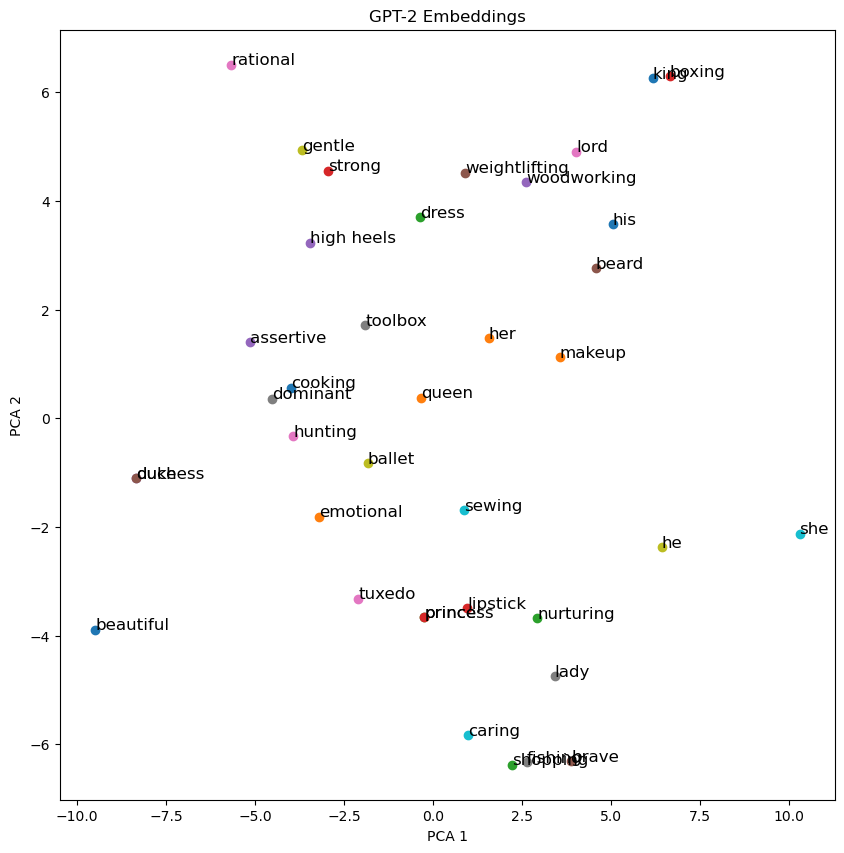

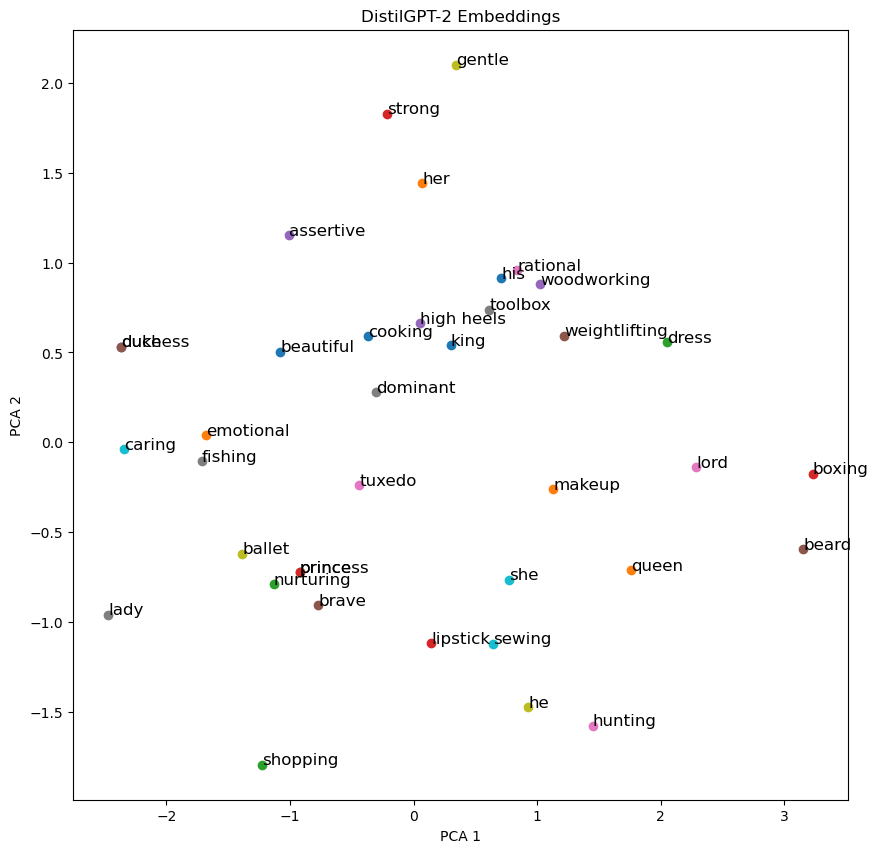

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import GPT2Model, GPT2Tokenizer, AutoModel, AutoTokenizer

# Set seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

def get_embeddings(model, tokenizer, text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True)
    with torch.no_grad():
        model_output = model(**encoded_input)
    return model_output.last_hidden_state[:, 0, :]

def plot_embeddings(embeddings, text, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(text):
        plt.scatter(pca_result[i, 0], pca_result[i, 1])
        plt.text(pca_result[i, 0], pca_result[i, 1], word, fontsize=12)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    plt.show()

# Text to be visualized
# Updated list of words for visualization
text = ["king", "queen", "prince", "princess", "duke", "duchess", "lord", "lady",
        "gentle", "caring", "beautiful", "emotional", "nurturing", 
        "strong", "assertive", "brave", "rational", "dominant",
        "ballet", "sewing", "cooking", "makeup", "shopping",
        "boxing", "woodworking", "weightlifting", "hunting", "fishing",
        "he", "she", "his", "her", "dress", "lipstick", "high heels",
        "beard", "tuxedo", "toolbox"]

# Load GPT-2 model and tokenizer, set pad token
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2Model.from_pretrained("gpt2")

# Load DistilGPT-2 model and tokenizer, set pad token
distilgpt2_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
distilgpt2_tokenizer.pad_token = distilgpt2_tokenizer.eos_token
distilgpt2_model = AutoModel.from_pretrained("distilgpt2")

# Get embeddings from both models
gpt2_embeddings = get_embeddings(gpt2_model, gpt2_tokenizer, text)
distilgpt2_embeddings = get_embeddings(distilgpt2_model, distilgpt2_tokenizer, text)

# Plot embeddings
plot_embeddings(gpt2_embeddings, text, "GPT-2 Embeddings")
plot_embeddings(distilgpt2_embeddings, text, "DistilGPT-2 Embeddings")


## Comparing Outputs from Different Models

In [23]:
from transformers import pipeline

# Set up pipelines for two different models
gpt2_pipeline = pipeline("text-generation", model="gpt2")
distilgpt2_pipeline = pipeline("text-generation", model="distilgpt2")

prompt = "The future of AI in healthcare"

# Generate text from GPT-2
gpt2_output = gpt2_pipeline(prompt, max_length=50)[0]['generated_text']

# Generate text from DistilGPT-2
distilgpt2_output = distilgpt2_pipeline(prompt, max_length=50)[0]['generated_text']

print("GPT-2 Output:\n", gpt2_output)
print("\nDistilGPT-2 Output:\n", distilgpt2_output)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT-2 Output:
 The future of AI in healthcare seems bright.

For a few reasons, it does seem increasingly obvious that AI isn't so far above our current limitations as the technology that saves lives. When one compares the cost of AI with human doctors, physicians

DistilGPT-2 Output:
 The future of AI in healthcare, and research. As a whole, this is very valuable to our scientific community.


<div class="alert alert-success">

## ❗ Key Points

* In causal (traditional) language models such as GPT, each token is predicted conditioning on the previous tokens. Given that the previous tokens are received by the decoder itself, you don't need an encoder.
* In Neural Machine Translation (NMT) models, each token of the translation is predicted conditioning on the previous tokens and the source sentence. The previous tokens are received by the decoder, but the source sentence is processed by a dedicated encoder.
* In masked LMs, like BERT, each masked token prediction is conditioned on the rest of the tokens in the sentence. These are received in the encoder, therefore you don't need an decoder. 
</div>